In [1]:
import numpy as np
import pandas as pd
import scipy.stats

pd.options.mode.chained_assignment = None
from matplotlib import pyplot as plt, rcParams
# import cv2
import seaborn as sns

sns.set(style="white", context="paper")
from cycler import cycler
import os, sys
import glob
from datetime import datetime, timedelta
from itertools import combinations, product
import base64
from PIL import Image
from io import BytesIO as _BytesIO
import requests
import json
import pickle
from datetime import datetime
from IPython.display import display, Markdown, Latex
from sklearn.metrics import *
import collections
from copy import deepcopy
import traceback
from sympy import Point, Polygon
from decorators import *
from smartprint import smartprint as sprint
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN
import mmcv
from mmtrack.apis import inference_mot, init_model as init_tracking_model
# import plotly
# from pandas_profiling import ProfileReport

pd.options.display.max_columns = None
def printm(s): return display(Markdown(s))
    
SERVER_CACHE_DIR = '/mnt/ci-nas-cache/edulyzeV2/cache_compute_4/fixed_face'
os.makedirs(SERVER_CACHE_DIR,exist_ok=True)

track_analysis_meta_cache = f'{SERVER_CACHE_DIR}/analysis_tracking/meta_info'
base_dir = '/mnt/ci-nas-cache/edulyzeV2/pose_face_gaze_emb_fixed_face/'

track_analysis_session_data = f'{SERVER_CACHE_DIR}/analysis_tracking/session_tracking_info'
os.makedirs(track_analysis_session_data,exist_ok=True)

postprocessed_id_map_data_dir = f'{SERVER_CACHE_DIR}/analysis_tracking/processed_id_maps'
os.makedirs(postprocessed_id_map_data_dir, exist_ok=True)

emb_analysis_session_data = f'{SERVER_CACHE_DIR}/analysis_emb/session_emb_info_new'
os.makedirs(emb_analysis_session_data,exist_ok=True)

embmatched_id_raw_data_dir = f'{SERVER_CACHE_DIR}/analysis_emb/embmatched_id_raw'
os.makedirs(embmatched_id_raw_data_dir,exist_ok=True)

embmatched_id_map_data_dir = f'{SERVER_CACHE_DIR}/analysis_tracking/embmatched_id_maps'
os.makedirs(embmatched_id_map_data_dir, exist_ok=True)

cross_session_input_data_dir = f'{SERVER_CACHE_DIR}/analysis_emb/cross_session_input'
os.makedirs(cross_session_input_data_dir, exist_ok=True)

case_study_input_data = f'{SERVER_CACHE_DIR}/case_studies_input_raw/'
os.makedirs(case_study_input_data,exist_ok=True)

id_viz_cache_root = f'{SERVER_CACHE_DIR}/analysis_emb/session_matching_info_new'
os.makedirs(id_viz_cache_root, exist_ok=True)

eval_viz_cache_root = f'{SERVER_CACHE_DIR}/analysis_emb/chi_eval_videos'
os.makedirs(eval_viz_cache_root, exist_ok=True)


/home/prasoon/anaconda3/envs/edusense/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/prasoon/anaconda3/envs/edusense/lib/python3.9/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


## Get frame file data for all sessions

In [2]:

frame_file_data = {}
for course_idx, course_dir in enumerate(glob.glob(f"{base_dir}/*")):
    course_name = course_dir.split("/")[-1]
    course_cache_file = f"{track_analysis_meta_cache}/{course_name}"
    if os.path.exists(course_cache_file):
        frame_file_data[course_name] = pickle.load(open(course_cache_file,"rb"))
        continue
    frame_file_data[course_name]={}
        
    for session_idx, session_dir in enumerate(glob.glob(f"{course_dir}/*")):
        session_name = session_dir.split("/")[-1]
        frame_file_data[course_name][session_name] = {}
        frame_files = glob.glob(f"{session_dir}/*")
        frame_file_names = [xr.split("/")[-1] for xr in frame_files]
        if 'end.pb' in frame_file_names:
            frame_file_data[course_name][session_name]['is_completed']=True
        else:
            frame_file_data[course_name][session_name]['is_completed']=False            
        frame_ids = [int(xr.split(".")[0]) for xr in frame_file_names if not (xr=='end.pb')]
        frame_file_data[course_name][session_name]['frame_ids'] = sorted(frame_ids)
        frame_file_data[course_name][session_name]['dir_location'] = session_dir
        print(f"Got metadata for course: {course_idx}-{course_name}, session:{session_idx}-{session_name}")
    pickle.dump(frame_file_data[course_name],open(course_cache_file,"wb")) 
        
frame_file_data.keys()

dict_keys(['05748A', '05410B', '17214C', '17214B', '05681A', '24352A', '24352C', '86375A'])

In [3]:
session_filter_list = [                       
 'classinsight-cmu_05748A_ghc_4101_201902141630',
 'classinsight-cmu_05748A_ghc_4101_201904021630',
 'classinsight-cmu_05748A_ghc_4101_201902051630',
 'classinsight-cmu_05748A_ghc_4101_201902281630',
 'classinsight-cmu_05748A_ghc_4101_201903071630',
                       
 'classinsight-cmu_17214B_ph_a21_201902271030',
 'classinsight-cmu_17214B_ph_a21_201903061030',
 'classinsight-cmu_17214B_ph_a21_201904031030',
 'classinsight-cmu_17214B_ph_a21_201904101030',
 'classinsight-cmu_17214B_ph_a21_201904241030',
                       
 'classinsight-cmu_17214C_ph_225b_201903201130',
 'classinsight-cmu_17214C_ph_225b_201904101130',
 'classinsight-cmu_17214C_ph_225b_201904171130',
 'classinsight-cmu_17214C_ph_225b_201904241130',
 'classinsight-cmu_17214C_ph_225b_201905011130',
]

# Get ID Counts for Vanilla MMTrack, Local ID Conciliation, Global ID Concilation

In [4]:
id_counts_post_filter = []

In [5]:
# sample_course = '05748A'
# sample_session_id = 'classinsight-cmu_05748A_ghc_4101_201903071630-front'
for session_id in session_filter_list:
    sample_session_id = f'{session_id}-front'
    sample_course = session_id.split("-")[-1].split("_")[1]
    sprint(sample_course, sample_session_id)
    session_tracking_cache_file = f"{track_analysis_session_data}/{sample_session_id}.pb"
    session_preprocessed_id_map_file = f"{postprocessed_id_map_data_dir}/{sample_session_id}.pb"
    session_frame_dir = f'{base_dir}/{sample_course}/{sample_session_id}'
    # session_video_file = f'/mnt/ci-nas-classes/classinsight/2019S/video_backup/{sample_session_id.split("-front")[0]}/{sample_session_id}.avi'
    # session_frame_dir
    
    old_to_new_id_map = pickle.load(open(session_preprocessed_id_map_file,"rb"))
    vanilla_mmtrack_ids = np.unique(list(old_to_new_id_map.keys())).tolist()
    local_conciliation_ids = np.unique(list(old_to_new_id_map.values())).tolist()
    non_ephemeral_ids = [xr for xr in old_to_new_id_map if not (old_to_new_id_map[xr]==10000)]
    local_conciliation_ids = [xr for xr in local_conciliation_ids if (not (xr==10000))]
    df_session_eligible_pairs = pd.read_csv(f"{embmatched_id_map_data_dir}/{sample_session_id}.csv")
    # Correct new ids with dict from eligible pairs
    eligible_id_map_dict = {}
    for id_pair in df_session_eligible_pairs.id_pair.values:
        (id1, id2) = eval(id_pair)
        # print(id1, id2)
        if id2 in eligible_id_map_dict:
            eligible_id_map_dict[id1] = eligible_id_map_dict[id2]
        else:
            eligible_id_map_dict[id2] = id1
    
    # sprint(eligible_id_map_dict)
    
    # correct created eligible map for once more
    for key in sorted(list(eligible_id_map_dict.keys())):
        key_value = eligible_id_map_dict[key]
        if key_value in eligible_id_map_dict.keys():
            eligible_id_map_dict[key] = eligible_id_map_dict[key_value]
    # sprint(eligible_id_map_dict) 
    # sprint({kr:old_to_new_id_map[kr] for kr in old_to_new_id_map if (not old_to_new_id_map[kr]==10000)}) 
    sprint("replacing ids in old to new id maps")
    for old_id in old_to_new_id_map:
        if old_to_new_id_map[old_id] in eligible_id_map_dict:
            # print(f"replacing {old_id}:{old_to_new_id_map[old_id]} -->{eligible_id_map_dict[old_to_new_id_map[old_id]]}")
            old_to_new_id_map[old_id] = eligible_id_map_dict[old_to_new_id_map[old_id]]
    # sprint({kr:old_to_new_id_map[kr] for kr in old_to_new_id_map if (not old_to_new_id_map[kr]==10000)}) 
    
    
    # map processed ids to tracking df
    df_tracking_new = pickle.load(open(session_tracking_cache_file,"rb")).transpose()
    total_idxs = df_tracking_new.index.max()
    for old_id in old_to_new_id_map:
        new_id = old_to_new_id_map[old_id]
        if not new_id==10000:
            new_id_col = f'N{new_id}'
            if new_id_col not in df_tracking_new:
                df_tracking_new[new_id_col] = None
            df_tracking_new[new_id_col] =  df_tracking_new[new_id_col].where(~df_tracking_new[new_id_col].isnull(), df_tracking_new[old_id])
        df_tracking_new = df_tracking_new.drop(old_id, axis=1)
    
    col_start_stop_idxs = []
    for col in df_tracking_new.columns:
        one_idxs = df_tracking_new.index[np.where(df_tracking_new[col]==1)[0]].values
        col_start_stop_idxs.append([col, one_idxs.min(), one_idxs.max()])
    df_id_start_stop = pd.DataFrame(col_start_stop_idxs, columns=['id','min_idx','max_idx'])
    df_id_start_stop['total_idxs'] = df_id_start_stop['max_idx']-df_id_start_stop['min_idx']
    df_id_start_stop['id'] = df_id_start_stop['id'].apply(lambda x: int(x[1:]))
    df_id_start_stop
    
    INSTRUCTOR_ID_THRESHOLD = df_id_start_stop.total_idxs.max()*0.1
    instructor_ids = df_id_start_stop[df_id_start_stop.total_idxs < INSTRUCTOR_ID_THRESHOLD]['id'].values
    df_id_post_global_reconciliation = df_id_start_stop[~(df_id_start_stop.id.isin(instructor_ids))]
    sprint(len(vanilla_mmtrack_ids), len(non_ephemeral_ids), len(local_conciliation_ids), df_id_start_stop.shape[0], df_id_post_global_reconciliation.shape[0])
    id_counts_post_filter.append([sample_course, session_id, len(vanilla_mmtrack_ids), len(non_ephemeral_ids), len(local_conciliation_ids), df_id_start_stop.shape[0], df_id_post_global_reconciliation.shape[0]])
    del df_tracking_new


sample_course, sample_session_id : 05748A classinsight-cmu_05748A_ghc_4101_201902141630-front
"replacing ids in old to new id maps" : replacing ids in old to new id maps


KeyboardInterrupt: 

In [42]:
df_id_counts = pd.DataFrame(id_counts_post_filter, columns=['course','session','OC-SORT-Only','OC-SORT+RemoveEphemeralIDs', 'OC-SORT+RemoveEphemeralIDs+LocalIDC', 'OC-SORT+RemoveEphemeralIDs+GlobalMatch', 'OC-SORT+RemoveEphemeralIDs+LocalIDC+GlobalIDC'])
df_id_counts

,course,session,OC-SORT-Only,OC-SORT+RemoveEphemeralIDs,OC-SORT+RemoveEphemeralIDs+LocalIDC,OC-SORT+RemoveEphemeralIDs+GlobalMatch,OC-SORT+RemoveEphemeralIDs+LocalIDC+GlobalIDC
0,05748A,classinsight-cmu_05748A_ghc_4101_201902141630,1391,54,37,31,18
1,05748A,classinsight-cmu_05748A_ghc_4101_201904021630,956,66,37,32,20
2,05748A,classinsight-cmu_05748A_ghc_4101_201902051630,1417,50,35,31,18
3,05748A,classinsight-cmu_05748A_ghc_4101_201902281630,1358,52,37,34,21
4,05748A,classinsight-cmu_05748A_ghc_4101_201903071630,1975,50,32,29,20
5,17214B,classinsight-cmu_17214B_ph_a21_201902271030,1247,40,17,16,14
6,17214B,classinsight-cmu_17214B_ph_a21_201903061030,1627,57,29,27,13
7,17214B,classinsight-cmu_17214B_ph_a21_201904031030,1707,31,18,15,9
8,17214B,classinsight-cmu_17214B_ph_a21_201904101030,1102,39,22,22,14
9,17214B,classinsight-cmu_17214B_ph_a21_201904241030,856,31,22,22,15


In [43]:
df_ids_all = pd.melt(df_id_counts, id_vars=['course','session'], var_name='ProcessingStep',value_name='UniqueSessionIDs')
df_ids_all['Session_Abbrv'] = df_ids_all.apply(lambda row: f'C:{row["course"]} Date:{row["session"].split("_")[-1][4:8]}', axis=1)
df_ids_all = df_ids_all.sort_values(by=['course','Session_Abbrv'])
df_ids_all

,course,session,ProcessingStep,UniqueSessionIDs,Session_Abbrv
2,05748A,classinsight-cmu_05748A_ghc_4101_201902051630,OC-SORT-Only,1417,C:05748A Date:0205
17,05748A,classinsight-cmu_05748A_ghc_4101_201902051630,OC-SORT+RemoveEphemeralIDs,50,C:05748A Date:0205
32,05748A,classinsight-cmu_05748A_ghc_4101_201902051630,OC-SORT+RemoveEphemeralIDs+LocalIDC,35,C:05748A Date:0205
47,05748A,classinsight-cmu_05748A_ghc_4101_201902051630,OC-SORT+RemoveEphemeralIDs+GlobalMatch,31,C:05748A Date:0205
62,05748A,classinsight-cmu_05748A_ghc_4101_201902051630,OC-SORT+RemoveEphemeralIDs+LocalIDC+GlobalIDC,18,C:05748A Date:0205
...,...,...,...,...,...
14,17214C,classinsight-cmu_17214C_ph_225b_201905011130,OC-SORT-Only,521,C:17214C Date:0501
29,17214C,classinsight-cmu_17214C_ph_225b_201905011130,OC-SORT+RemoveEphemeralIDs,41,C:17214C Date:0501
44,17214C,classinsight-cmu_17214C_ph_225b_201905011130,OC-SORT+RemoveEphemeralIDs+LocalIDC,26,C:17214C Date:0501
59,17214C,classinsight-cmu_17214C_ph_225b_201905011130,OC-SORT+RemoveEphemeralIDs+GlobalMatch,26,C:17214C Date:0501


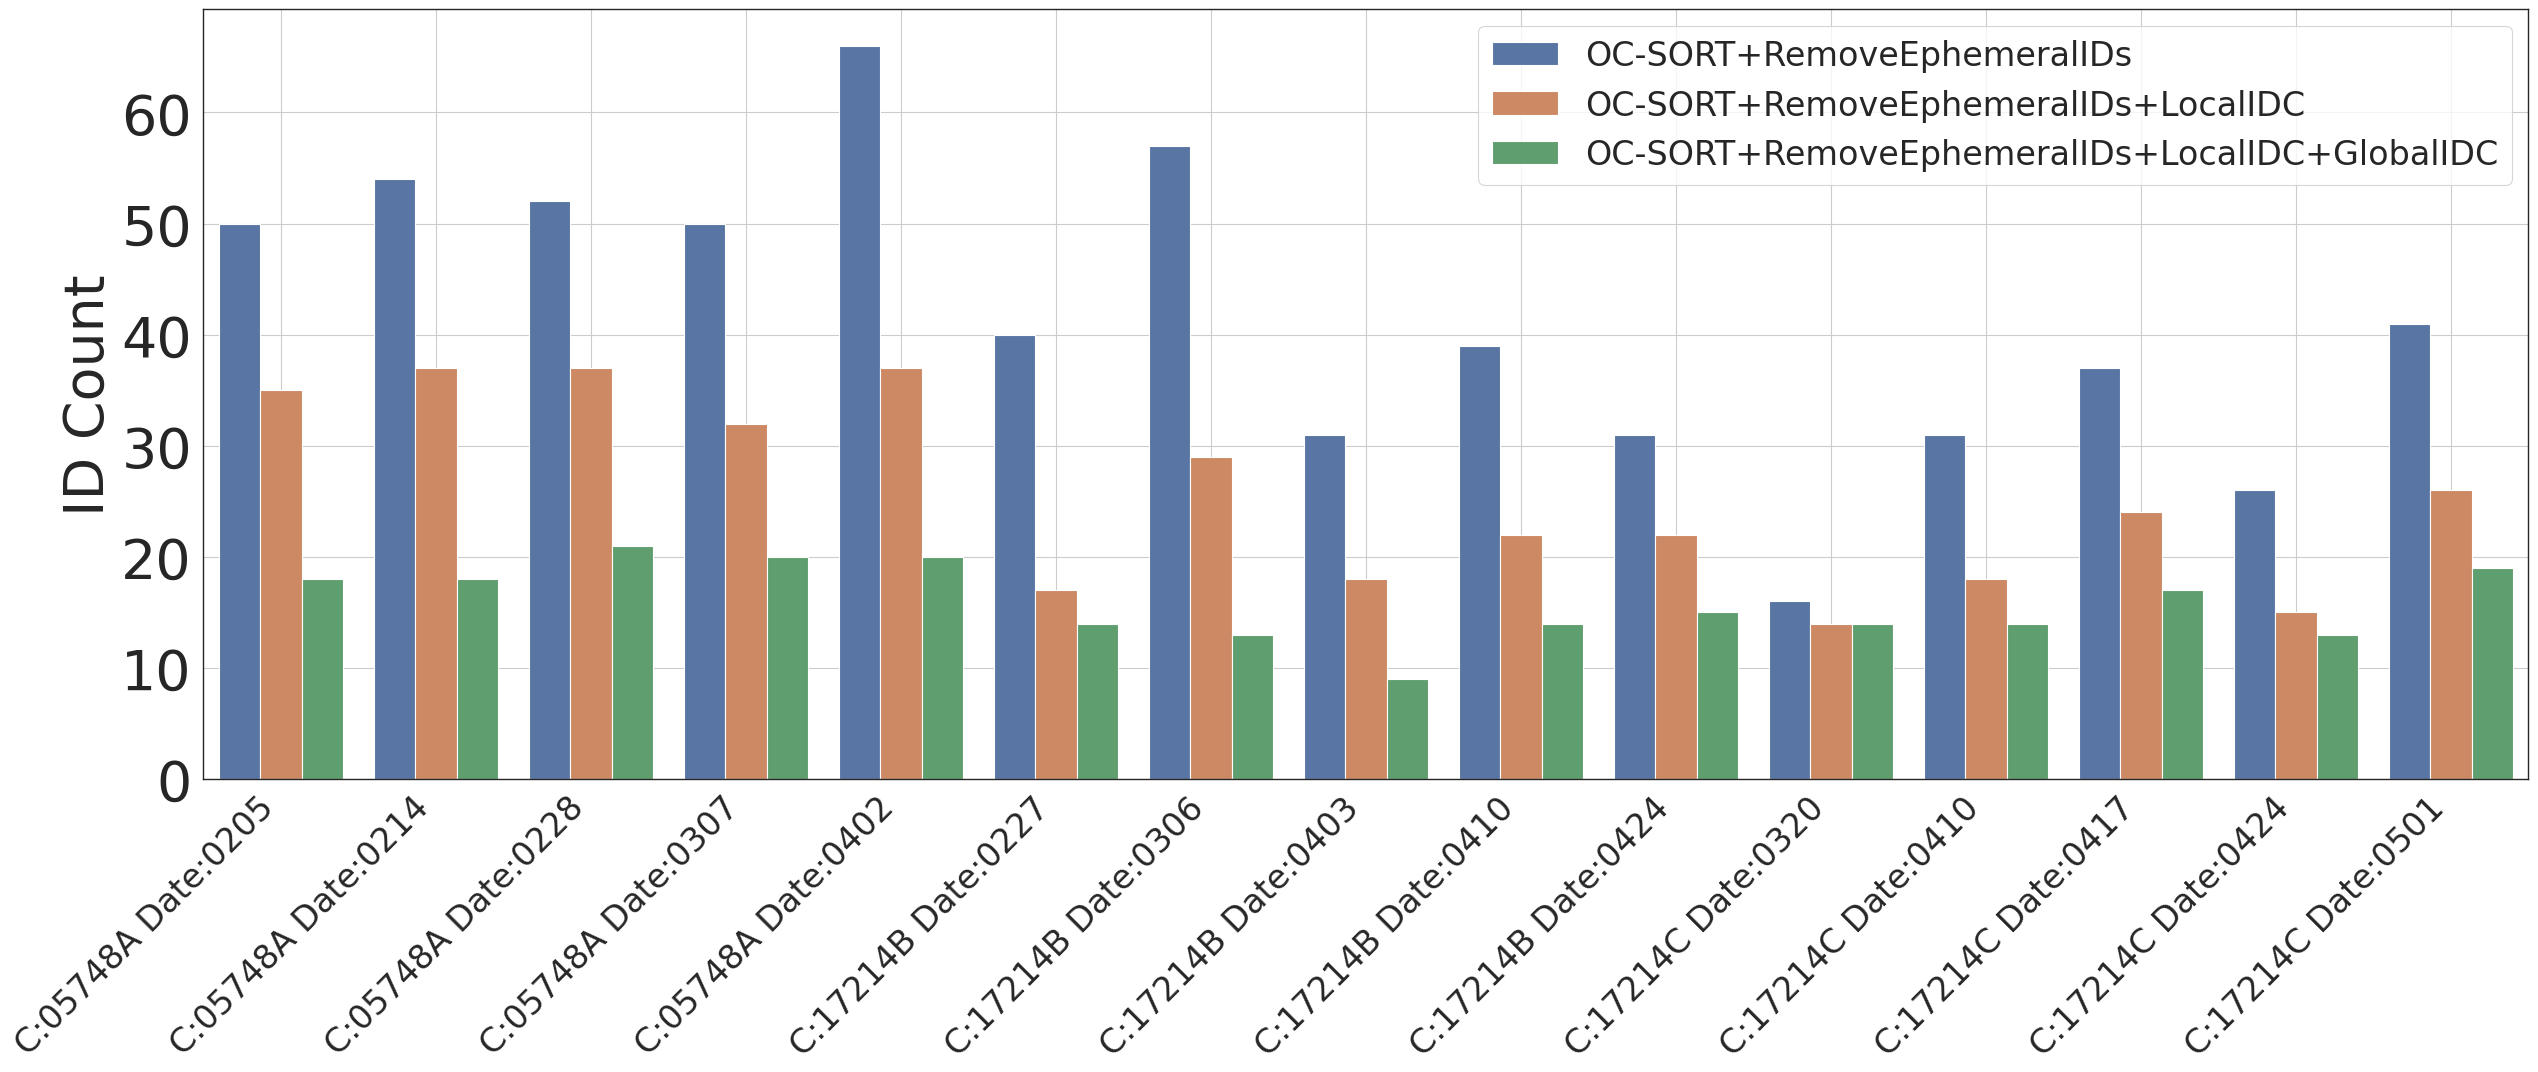

In [45]:
plt.figure(figsize=(30,10))
sns.barplot(df_ids_all[(~(df_ids_all.ProcessingStep=='OC-SORT-Only')) & (~(df_ids_all.ProcessingStep=='OC-SORT+RemoveEphemeralIDs+GlobalMatch'))], x='Session_Abbrv',y='UniqueSessionIDs',hue='ProcessingStep')
plt.yticks(fontsize=40)
plt.ylabel('ID Count', fontsize=40)
plt.xticks(rotation=45, fontsize=24,ha='right')
plt.legend(fontsize=24)
plt.xlabel('')
plt.grid()
plt.savefig("id_count_final.png",bbox_inches='tight',dpi=150)

In [9]:
df_id_start_stop.total_idxs.max()*0.1

6676.8

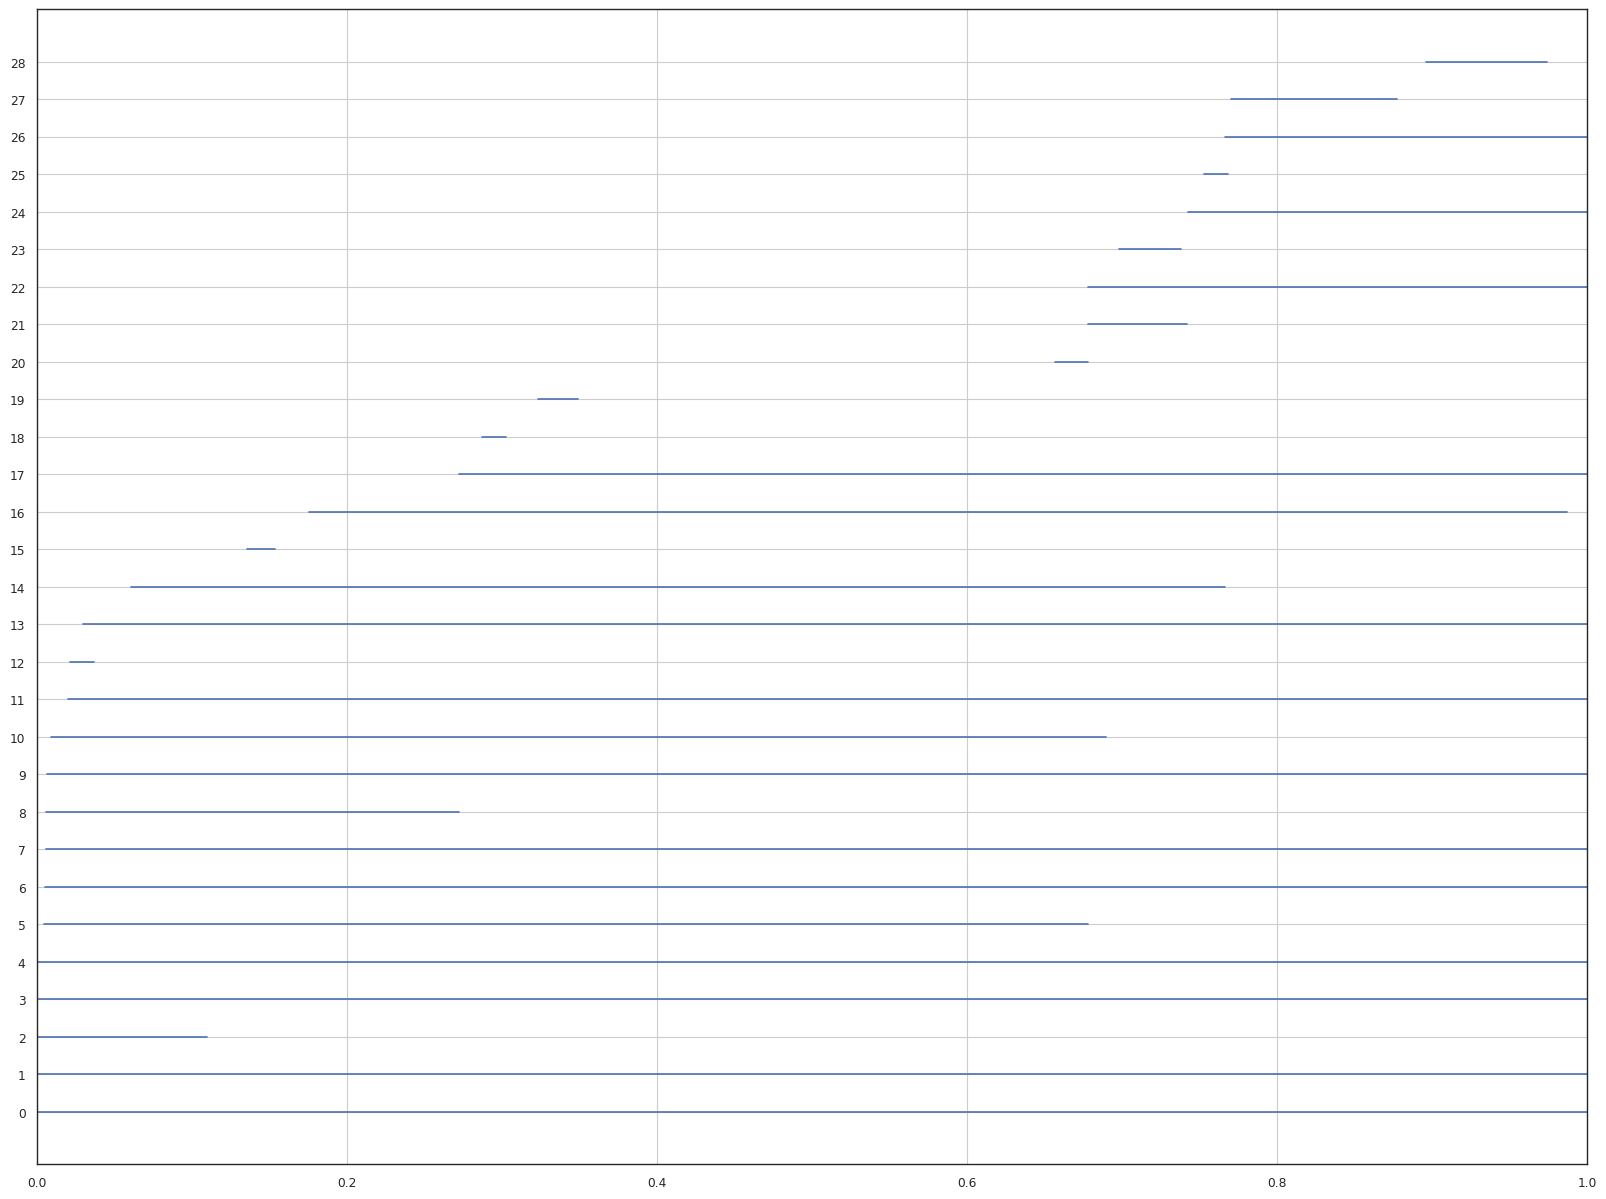

In [10]:
_ = plt.figure(figsize=(20,15))
for row_idx, row in df_id_start_stop.iterrows():
    plt.axhline(y=row_idx, xmin=row['min_idx']/total_idxs,xmax=row['max_idx']/total_idxs)
plt.yticks(range(df_id_start_stop.shape[0]), range(df_id_start_stop.shape[0]))
plt.grid() 

In [11]:
INSTRUCTOR_ID_THRESHOLD = df_id_start_stop.total_idxs.max()*0.1
instructor_ids = df_id_start_stop[df_id_start_stop.total_idxs < INSTRUCTOR_ID_THRESHOLD]['id'].values
instructor_ids

array([12, 15, 18, 20, 21, 22, 24, 27, 30])

In [12]:
# find random frames to mark for GT from session
# np.random.seed(42)

MAX_SESSION_IDX = df_id_start_stop.max_idx.max()
NUM_SEGMENTS =3
SEG_START_MIN = 0.1
SEG_START_MAX=0.9
SET_SIZE = 60*15
SEGMENT_WINDOW_SIZE = (SEG_START_MAX - SEG_START_MIN)/NUM_SEGMENTS

session_frames = df_tracking_new.index.values.tolist()
selected_frames = []
selected_sets = []

for i in range(NUM_SEGMENTS):    
    seg_window =  np.arange(int((SEG_START_MIN + (i*SEGMENT_WINDOW_SIZE))* MAX_SESSION_IDX), int((SEG_START_MIN + ((i+1)*SEGMENT_WINDOW_SIZE))* MAX_SESSION_IDX) - SET_SIZE) 
    seg_set_start = np.random.choice(seg_window)
    seg_set_end = seg_set_start+SET_SIZE
    segment_frames = [xr for xr in session_frames if ((xr >= seg_set_start) and (xr<seg_set_end))]
    selected_sets.append((seg_set_start, seg_set_end, segment_frames))
    selected_frames+=segment_frames        

sprint(selected_sets)

List: selected_sets


[
    (
        16756,
        17656,
        [
            16758,
            16761,
            16764,
            16767,
            16770,
            16773,
            16776,
            16779,
            16782,
            16785,
            16788,
            16791,
            16794,
            16797,
            16800,
            16803,
            16806,
            16809,
            16812,
            16815,
            16818,
            16821,
            16824,
            16827,
            16830,
            16833,
            16836,
            16839,
            16842,
            16845,
            16848,
            16851,
            16854,
            16857,
            16860,
            16863,
            16866,
            16869,
            16872,
            16875,
            16878,
            16881,
            16884,
            16887,
            16890,
            16893,
            16896,
            16899,
            16902,
            16905,
            16908,
            16911,
            16914,
            16917,
            16920,
            16923,
            16926,
            16929,
            16932,
            16935,
            16938,
            16941,
            16944,
            16947,
            16950,
            16953,
            16956,
            16959,
            16962,
            16965,
            16968,
            16971,
            16974,
            16977,
            16980,
            16983,
            16986,
            16989,
            16992,
            16995,
            16998,
            17001,
            17004,
            17007,
            17010,
            17013,
            17016,
            17019,
            17022,
            17025,
            17028,
            17031,
            17034,
            17037,
            17040,
            17043,
            17046,
            17049,
            17052,
            17055,
            17058,
            17061,
            17064,
            17067,
            17070,
            17073,
            17076,
            17079,
            17082,
            17085,
            17088,
            17091,
            17094,
            17097,
            17100,
            17103,
            17106,
            17109,
            17112,
            17115,
            17118,
            17121,
            17124,
            17127,
            17130,
            17133,
            17136,
            17139,
            17142,
            17145,
            17148,
            17151,
            17154,
            17157,
            17160,
            17163,
            17166,
            17169,
            17172,
            17175,
            17178,
            17181,
            17184,
            17187,
            17190,
            17193,
            17196,
            17199,
            17202,
            17205,
            17208,
            17211,
            17214,
            17217,
            17220,
            17223,
            17226,
            17229,
            17232,
            17235,
            17238,
            17241,
            17244,
            17247,
            17250,
            17253,
            17256,
            17259,
            17262,
            17265,
            17268,
            17271,
            17274,
            17277,
            17280,
            17283,
            17286,
            17289,
            17292,
            17295,
            17298,
            17301,
            17304,
            17307,
            17310,
            17313,
            17316,
            17319,
            17322,
            17325,
            17328,
            17331,
            17334,
            17337,
            17340,
            17343,
            17346,
            17349,
            17352,
            17355,
            17358,
            17361,
            17364,
            17367,
            17370,
            17373,
            17376,
            17379,


In [13]:
len(selected_frames)

900

In [14]:
SOURCE_ROOT = '/home/prasoon/video_analysis/edusenseV2compute/compute/videoV3'
run_config = {
    'track_config':f'{SOURCE_ROOT}/configs/mmlab/ocsort_yolox_x_crowdhuman_mot17-private-half.py',
    'track_checkpoint':f'{SOURCE_ROOT}/models/mmlab/ocsort_yolox_x_crowdhuman_mot17-private-half_20220813_101618-fe150582.pth',
    'device':'cuda:1',
}


In [15]:
# for given frame ranges get video frames and tracking results
all_frames = mmcv.VideoReader(session_video_file)

required_frame_ids = np.unique(sorted(selected_frames))
frame_data_dict = {}

for frame_idx, frame_img in enumerate(all_frames):
    if (frame_idx in required_frame_ids) & (frame_idx%3==0):
        frame_data_dict[frame_idx] = frame_img
    if frame_idx%10000==0:
        print(f"Looped {frame_idx} images")

Looped 0 images


[h264 @ 0xa7340c0] error while decoding MB 151 91, bytestream -7
[h264 @ 0xb942240] error while decoding MB 141 113, bytestream -5
[h264 @ 0xa71fc80] error while decoding MB 191 22, bytestream -10
[h264 @ 0x9e62b00] cabac decode of qscale diff failed at 173 36
[h264 @ 0x9e62b00] error while decoding MB 173 36, bytestream 265707
[h264 @ 0xa778e40] error while decoding MB 200 106, bytestream -5
[h264 @ 0xb872e40] error while decoding MB 178 83, bytestream -5
[h264 @ 0xbae09c0] left block unavailable for requested intra4x4 mode -1
[h264 @ 0xbae09c0] error while decoding MB 0 30, bytestream 317279
[h264 @ 0x9aaca80] error while decoding MB 76 25, bytestream -8
[h264 @ 0x9aaca80] error while decoding MB 115 64, bytestream -5
[h264 @ 0x99e2900] error while decoding MB 112 20, bytestream -7
[h264 @ 0xa764a40] cabac decode of qscale diff failed at 35 64
[h264 @ 0xa764a40] error while decoding MB 35 64, bytestream 7376
[h264 @ 0xba11600] error while decoding MB 5 128, bytestream -7
[h264 @ 0x9d

Looped 10000 images


[h264 @ 0xa778e40] error while decoding MB 195 44, bytestream -5
[h264 @ 0x9d42480] error while decoding MB 135 84, bytestream -5
[h264 @ 0xb942240] error while decoding MB 90 124, bytestream -7
[h264 @ 0xd5b2680] cabac decode of qscale diff failed at 125 30
[h264 @ 0xd5b2680] error while decoding MB 125 30, bytestream 312353
[h264 @ 0xbae09c0] error while decoding MB 200 100, bytestream -9
[h264 @ 0x9aaca80] cabac decode of qscale diff failed at 58 40
[h264 @ 0x9aaca80] error while decoding MB 58 40, bytestream 299682
[h264 @ 0x9d42480] error while decoding MB 103 102, bytestream -5
[h264 @ 0xa764a40] error while decoding MB 197 25, bytestream -9
[h264 @ 0xd5b2680] error while decoding MB 161 47, bytestream -5
[h264 @ 0xa778e40] error while decoding MB 187 58, bytestream -5
[h264 @ 0xb942240] error while decoding MB 92 28, bytestream -7
[h264 @ 0xa764a40] error while decoding MB 213 77, bytestream -5
[h264 @ 0xbae09c0] error while decoding MB 200 22, bytestream -9
[h264 @ 0xa750640] e

Looped 20000 images


[h264 @ 0xba11600] error while decoding MB 202 8, bytestream -50
[h264 @ 0xa750640] error while decoding MB 208 13, bytestream -18
[h264 @ 0xa750640] error while decoding MB 90 12, bytestream -12
[h264 @ 0x9d2e080] error while decoding MB 211 129, bytestream -9
[h264 @ 0xba11600] cabac decode of qscale diff failed at 180 8
[h264 @ 0xba11600] error while decoding MB 180 8, bytestream 64439
[h264 @ 0xa7340c0] error while decoding MB 151 112, bytestream -11
[h264 @ 0xb942240] error while decoding MB 2 78, bytestream -6
[h264 @ 0xa750640] error while decoding MB 2 133, bytestream -16
[h264 @ 0xbae09c0] error while decoding MB 207 94, bytestream -5
[h264 @ 0xa71fc80] cabac decode of qscale diff failed at 168 21
[h264 @ 0xa71fc80] error while decoding MB 168 21, bytestream 446395
[h264 @ 0xa750640] error while decoding MB 164 126, bytestream -5
[h264 @ 0x9d2e080] error while decoding MB 188 32, bytestream -7
[h264 @ 0xba11600] error while decoding MB 70 79, bytestream -5
[h264 @ 0x9aaca80] e

Looped 30000 images


[h264 @ 0xa7484c0] error while decoding MB 100 104, bytestream -5
[h264 @ 0x9d2e080] error while decoding MB 104 85, bytestream -5
[h264 @ 0xa7340c0] error while decoding MB 124 65, bytestream -5
[h264 @ 0xa7340c0] error while decoding MB 37 101, bytestream -5
[h264 @ 0x99e2900] error while decoding MB 98 84, bytestream -7
[h264 @ 0xa764a40] left block unavailable for requested intra mode
[h264 @ 0xa764a40] error while decoding MB 0 51, bytestream 362877
[h264 @ 0xd5b2680] error while decoding MB 168 75, bytestream -5
[h264 @ 0xb942240] error while decoding MB 83 101, bytestream -5
[h264 @ 0xb872e40] error while decoding MB 155 104, bytestream -9
[h264 @ 0xa7484c0] error while decoding MB 215 133, bytestream -11
[h264 @ 0xbae09c0] error while decoding MB 10 127, bytestream -5
[h264 @ 0x9d2e080] error while decoding MB 198 73, bytestream -5
[h264 @ 0xbae09c0] error while decoding MB 4 125, bytestream -5
[h264 @ 0x9d42480] error while decoding MB 187 55, bytestream -5
[h264 @ 0xbae09c0] 

Looped 40000 images


[h264 @ 0x9e62b00] error while decoding MB 150 53, bytestream -5
[h264 @ 0xa7484c0] error while decoding MB 157 24, bytestream -5
[h264 @ 0xbae09c0] error while decoding MB 209 62, bytestream -5
[h264 @ 0xa7484c0] error while decoding MB 103 76, bytestream -25
[h264 @ 0x9aaca80] error while decoding MB 101 65, bytestream -5
[h264 @ 0xd5b2680] cabac decode of qscale diff failed at 83 66
[h264 @ 0xd5b2680] error while decoding MB 83 66, bytestream 178026
[h264 @ 0xa750640] error while decoding MB 81 83, bytestream -11
[h264 @ 0x9d2e080] error while decoding MB 69 34, bytestream -5
[h264 @ 0x9aaca80] cabac decode of qscale diff failed at 44 71
[h264 @ 0x9aaca80] error while decoding MB 44 71, bytestream 158908
[h264 @ 0xba11600] error while decoding MB 142 117, bytestream -7
[h264 @ 0xa71fc80] error while decoding MB 104 83, bytestream -9
[h264 @ 0xba11600] error while decoding MB 102 81, bytestream -9
[h264 @ 0xa7484c0] error while decoding MB 83 57, bytestream -5
[h264 @ 0x9aaca80] erro

Looped 50000 images


[h264 @ 0xd5b2680] error while decoding MB 80 47, bytestream -5
[h264 @ 0xba11600] error while decoding MB 57 117, bytestream -7
[h264 @ 0x9aaca80] error while decoding MB 131 67, bytestream -5
[h264 @ 0xb872e40] error while decoding MB 95 51, bytestream -5
[h264 @ 0xa750640] error while decoding MB 39 12, bytestream -10
[h264 @ 0x9aaca80] error while decoding MB 111 59, bytestream -5
[h264 @ 0xa778e40] error while decoding MB 204 23, bytestream -24
[h264 @ 0xa71fc80] error while decoding MB 206 93, bytestream -5
[h264 @ 0xba11600] error while decoding MB 182 32, bytestream -12
[h264 @ 0x9aaca80] error while decoding MB 73 30, bytestream -20
[h264 @ 0xb872e40] error while decoding MB 197 55, bytestream -5
[h264 @ 0x99e2900] error while decoding MB 137 121, bytestream -7
[h264 @ 0xa71fc80] error while decoding MB 84 17, bytestream -15
[h264 @ 0xb942240] error while decoding MB 73 72, bytestream -5
[h264 @ 0x99e2900] error while decoding MB 70 102, bytestream -5
[h264 @ 0xb872e40] error 

Looped 60000 images


[h264 @ 0xba11600] error while decoding MB 131 108, bytestream -5
[h264 @ 0xbae09c0] error while decoding MB 195 9, bytestream -5
[h264 @ 0xa7484c0] error while decoding MB 182 55, bytestream -5
[h264 @ 0x9aaca80] error while decoding MB 122 63, bytestream -11
[h264 @ 0xbae09c0] error while decoding MB 57 41, bytestream -5
[h264 @ 0xa7484c0] error while decoding MB 109 100, bytestream -5
[h264 @ 0xbae09c0] error while decoding MB 189 40, bytestream -5
[h264 @ 0xa7484c0] error while decoding MB 226 96, bytestream -7
[h264 @ 0xb872e40] error while decoding MB 194 78, bytestream -5
[h264 @ 0xa71fc80] error while decoding MB 210 77, bytestream -9
[h264 @ 0x99e2900] error while decoding MB 200 91, bytestream -5
[h264 @ 0x9d2e080] error while decoding MB 12 88, bytestream -13
[h264 @ 0xba11600] error while decoding MB 73 74, bytestream -5
[h264 @ 0xa750640] error while decoding MB 29 73, bytestream -5
[h264 @ 0xd5b2680] error while decoding MB 101 78, bytestream -5
[h264 @ 0xa750640] error w

In [16]:
import cv2
session_id_viz_dir = f'{eval_viz_cache_root}/{sample_session_id}'
font = cv2.FONT_HERSHEY_DUPLEX
os.makedirs(session_id_viz_dir, exist_ok=True)
tracking_model =None
if tracking_model:
    printm("# Deleting Previous Model")
    del tracking_model
tracking_model = init_tracking_model(run_config['track_config'],
                                 run_config['track_checkpoint'],
                                 device=run_config['device'])
for seg_idx, (seg_start, seg_end, segment_frames) in enumerate(selected_sets):
    seg_video_id = f'S{seg_idx}_{int(seg_start)}_{int(seg_end)}'
    match_cache_dir = f'{session_id_viz_dir}/{seg_video_id}'
    match_video_file = f'{session_id_viz_dir}/{seg_video_id}_new.mp4'
    if os.path.exists(match_video_file):
        continue
    print(match_video_file)
    os.makedirs(match_cache_dir, exist_ok=True)
    frame_num=0

    for frame_idx in segment_frames:
        frame_tracking_file = f"{session_frame_dir}/{frame_idx}.pb"
        if os.path.exists(frame_tracking_file) and (frame_idx in frame_data_dict):
            frame_file_out = os.path.join(match_cache_dir, f'{frame_num:06d}.jpg')
            frame_num+=1
            if os.path.exists(frame_file_out):
                continue
            frame_tracking_results = pickle.load(open(frame_tracking_file,"rb"))[1]
            for person_idx in range(len(frame_tracking_results)):
                old_id= int(frame_tracking_results[person_idx]['track_id'])
                new_id = old_to_new_id_map[old_id]
                if new_id in instructor_ids:
                    new_id = 1000+new_id
                frame_tracking_results[person_idx]['track_id'] =new_id
            frame_img = deepcopy(frame_data_dict[frame_idx])
            if len(frame_tracking_results)>0:
                frame_tracking_results = {
                    'track_bboxes':[np.array([[xr['track_id']]+xr['bbox'].tolist() for xr in frame_tracking_results])],
                    'det_bboxes':[np.array([xr['bbox'].tolist() for xr in frame_tracking_results])]}
                frame_img = cv2.putText(frame_img,
                   f'frame_idx:{frame_idx}',
                   (frame_img.shape[1]//2, frame_img.shape[0]//2+1000),
                   font, 2,
                   (255, 255, 255),
                   2)
                frame_track_img = tracking_model.show_result(
                    frame_img,
                    frame_tracking_results,
                    thickness=5,
                    font_scale=.5,
                    score_thr=0.1,
                    show=False,
                    wait_time=int(1000. / 5),
                    out_file=frame_file_out,
                    backend='cv2')
                # cv2.imwrite(f'frame_test/{frame_idx}.jpg',frame_track_img)
            else:
                cv2.imwrite(frame_file_out,frame_img)
                
    
    #         break
    # break
    mmcv.frames2video(match_cache_dir, match_video_file, fps=10, fourcc='mp4v')
    print(f"Done for segment {seg_video_id}")
    # break
    
    

2023-09-12 11:22:10,106 - mmdet - INFO - image shape: height=800, width=1440 in YOLOX.__init__
2023-09-12 11:22:10,515 - mmtrack - INFO - initialize YOLOX with init_cfg {'type': 'Pretrained', 'checkpoint': 'https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth'}
2023-09-12 11:22:10,516 - mmcv - INFO - load model from: https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth
2023-09-12 11:22:10,517 - mmcv - INFO - load checkpoint from http path: https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth
2023-09-12 11:22:12,677 - mmcv - WARNING - The model and loaded state dict do not match exactly

size mismatch for bbox_head.multi_level_conv_cls.0.weight: copying a param with shape torch.Size([80, 320, 1, 1]) from checkpoint, the shape in current model is torch.Size([1, 320, 1, 

load checkpoint from local path: /home/prasoon/video_analysis/edusenseV2compute/compute/videoV3/models/mmlab/ocsort_yolox_x_crowdhuman_mot17-private-half_20220813_101618-fe150582.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: ema_detector_backbone_stem_conv_conv_weight, ema_detector_backbone_stem_conv_bn_weight, ema_detector_backbone_stem_conv_bn_bias, ema_detector_backbone_stem_conv_bn_running_mean, ema_detector_backbone_stem_conv_bn_running_var, ema_detector_backbone_stem_conv_bn_num_batches_tracked, ema_detector_backbone_stage1_0_conv_weight, ema_detector_backbone_stage1_0_bn_weight, ema_detector_backbone_stage1_0_bn_bias, ema_detector_backbone_stage1_0_bn_running_mean, ema_detector_backbone_stage1_0_bn_running_var, ema_detector_backbone_stage1_0_bn_num_batches_tracked, ema_detector_backbone_stage1_1_main_conv_conv_weight, ema_detector_backbone_stage1_1_main_conv_bn_weight, ema_detector_backbone_stage1_1_main_conv_bn_bias, ema_detector